A few references:

* [ARVIZ API](https://python.arviz.org/en/latest/api/index.html)
* [PYMC API](https://www.pymc.io/projects/docs/en/stable/api.html)
* [xarray API](https://docs.xarray.dev/en/stable/api.html)
* [daft](https://docs.daft-pgm.org/en/latest/): &nbsp; [daft & complete pooling](https://www.tensorflow.org/probability/examples/Multilevel_Modeling_Primer#41_complete_pooling_model)
* [graphviz](https://graphviz.readthedocs.io/en/stable/api.html): &nbsp; [pymc.model_to_graphviz](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.model_to_graphviz.html), <a href="https://www.pymc.io/projects/docs/en/stable/_modules/pymc/model_graph.html#:~:text=VarName%22%2C%20str)%0A%0A%0Aclass-,ModelGraph,-%3A%0A%20%20%20%20def%20__init__(self"> pymc.model_graph.ModelGraph</a>

<br>

# Preliminaries

In [1]:
!python --version

Python 3.8.13


<br>

## Environment

In [2]:
import os
import pathlib

<br>

Set path

In [3]:
os.chdir(path=str(pathlib.Path(os.getcwd()).parent))
os.getcwd()

'J:\\library\\plausibilities\\delineating'

<br>

## Libraries

In [4]:
%matplotlib inline

In [5]:
import logging
import collections

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import numpy as np
import pandas as pd
import seaborn as sns

import arviz as az
import pymc as pm
import xarray as xr
import aesara.tensor as at
import graphviz

<br>

Versions

In [6]:
az.__version__

'0.13.0'

In [7]:
pm.__version__

'4.3.0'

In [8]:
np.__version__

'1.22.3'

<br>

## Custom

In [9]:
import src.graphics.settings
import src.graphics.sketch
import src.graphics.models

import src.data.radioactivity
import src.data.features
import src.data.coordinates

import src.models.complete
import src.models.unpooled
import src.models.partial
import src.models.inference
import src.models.mapping

<br>

Aesthetics

In [10]:
settings = src.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

For diagrams/figures
* The `Labels` class is for `sketch.annotation(ax, Labels(title='...', xlabel='...', ylabel='...'))`

In [11]:
sketch = src.graphics.sketch.Sketch()
Labels = collections.namedtuple(typename='Labels', field_names=['title', 'xlabel', 'ylabel'])

<br>

For the DAG (directed acyclic graph) of models

In [12]:
path = os.path.join(os.getcwd(), 'notebooks')
dag = src.graphics.models.Models(path=path)

<br>

## Settings

Seed

In [13]:
RANDOM_SEED = 8924

<br>

Graphing

In [14]:
az.style.use('arviz-darkgrid')

<br>

## Logging

In [15]:
logging.basicConfig(level=logging.INFO, 
                    format='\n%(message)s\n%(asctime)s.%(msecs)03d\n', 
                    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

<br>
<br>

# Data

Excerpt: Focusing on Minnesota, MN, dwellings.

In [16]:
excerpt = src.data.radioactivity.Radioactivity().exc(state='MN')
logger.info(excerpt.columns)
logger.info(f'# of instances: {excerpt.shape}')
logger.info(f"# of unique codes: {excerpt['idnum'].unique().shape}")


Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips', 'Uppm'],
      dtype='object')
2022-11-28 15:53:07.738


# of instances: (919, 27)
2022-11-28 15:53:07.740


# of unique codes: (919,)
2022-11-28 15:53:07.742



<br>

Extra features

In [17]:
excerpt = src.data.features.Features().exc(data=excerpt)
logger.info(excerpt.columns)
logger.info(f'# of instances: {excerpt.shape}')
logger.info(f"# of unique codes: {excerpt['idnum'].unique().shape}")


Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips', 'Uppm', 'ln_radon',
       'countyindex'],
      dtype='object')
2022-11-28 15:53:09.562


# of instances: (919, 29)
2022-11-28 15:53:09.564


# of unique codes: (919,)
2022-11-28 15:53:09.566



<br>

Frequencies

In [18]:
frequencies = excerpt[['county', 'countyindex', 'floor']].groupby(by=['county', 'countyindex', 'floor']).value_counts()
frequencies.rename('N', inplace=True)
frequencies = frequencies.to_frame()
frequencies.reset_index(drop=False, inplace=True)
logger.info(frequencies.head())


   county  countyindex  floor   N
0  AITKIN            0      0   3
1  AITKIN            0      1   1
2   ANOKA            1      0  49
3   ANOKA            1      1   3
4  BECKER            2      0   1
2022-11-28 15:53:18.519



<br>
<br>

# Exploratory Graphs

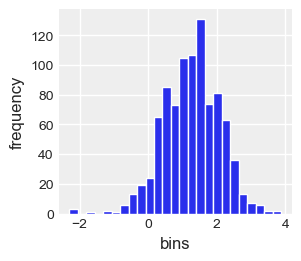

In [19]:
ax = sketch.figure(width=2.9, height=2.5)
ax.hist(excerpt.ln_radon, bins=25)
sketch.annotation(ax, Labels(title='', xlabel='bins', ylabel='frequency'))

<br>
<br>

# Models

The model's initial co$\ddot{o}$rdinates

In [20]:
coords = src.data.coordinates.Coordinates(data=excerpt).exc()
logger.info(coords)


{'Level': {'Basement': 0, 'Ground': 1}, 'County': {'AITKIN': 0, 'ANOKA': 1, 'BECKER': 2, 'BELTRAMI': 3, 'BENTON': 4, 'BIG STONE': 5, 'BLUE EARTH': 6, 'BROWN': 7, 'CARLTON': 8, 'CARVER': 9, 'CASS': 10, 'CHIPPEWA': 11, 'CHISAGO': 12, 'CLAY': 13, 'CLEARWATER': 14, 'COOK': 15, 'COTTONWOOD': 16, 'CROW WING': 17, 'DAKOTA': 18, 'DODGE': 19, 'DOUGLAS': 20, 'FARIBAULT': 21, 'FILLMORE': 22, 'FREEBORN': 23, 'GOODHUE': 24, 'HENNEPIN': 25, 'HOUSTON': 26, 'HUBBARD': 27, 'ISANTI': 28, 'ITASCA': 29, 'JACKSON': 30, 'KANABEC': 31, 'KANDIYOHI': 32, 'KITTSON': 33, 'KOOCHICHING': 34, 'LAC QUI PARLE': 35, 'LAKE': 36, 'LAKE OF THE WOODS': 37, 'LE SUEUR': 38, 'LINCOLN': 39, 'LYON': 40, 'MAHNOMEN': 41, 'MARSHALL': 42, 'MARTIN': 43, 'MCLEOD': 44, 'MEEKER': 45, 'MILLE LACS': 46, 'MORRISON': 47, 'MOWER': 48, 'MURRAY': 49, 'NICOLLET': 50, 'NOBLES': 51, 'NORMAN': 52, 'OLMSTED': 53, 'OTTER TAIL': 54, 'PENNINGTON': 55, 'PINE': 56, 'PIPESTONE': 57, 'POLK': 58, 'POPE': 59, 'RAMSEY': 60, 'REDWOOD': 61, 'RENVILLE': 62, 

<br>
<br>

## Complete

Add more notes:

* A simple linear regression model: an intercept, a gradient whereby the accompanying independent variable is *dwelling level*, i.e., basement or ground level.
* The dependent variable is *ln(radon)*
* Is the *intercept* implicit below?



<br>

### Model


The model

In [21]:
complete = src.models.complete.Complete(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The # of level group elements: (2,)
2022-11-27 23:00:19.424


The shape of mu, whereby mu = measures[levelcode]: (919,)
2022-11-27 23:00:19.461


y
2022-11-27 23:00:19.485



<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(complete)`

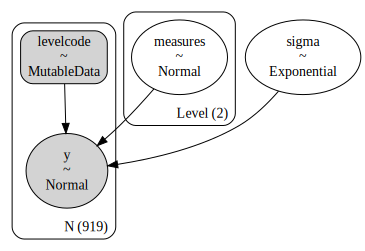

In [22]:
name = 'complete.gv'
dag.exc(model=complete, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

* `inferences.keys()`

* `inferences.get('prior').keys()`


In [23]:
evidence = src.models.inference.Inference(model=complete).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-11-27 23:00:20.708

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-11-27 23:00:20.710

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-11-27 23:00:23.963

NUTS: [measures, sigma]

NUTS: [measures, sigma]
2022-11-27 23:00:23.965



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
2022-11-27 23:00:54.222

Sampling: [measures, sigma, y]

Sampling: [measures, sigma, y]
2022-11-27 23:01:00.128

Sampling: [y]

Sampling: [y]
2022-11-27 23:01:00.291



In [24]:
evidence = src.models.mapping.Mapping(inferences=evidence, coords=coords).exc()

In [25]:
evidence

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

### Prior Measures

<br>

**Prior Measures: Distributions**



In [26]:
computations = []

for k, v in coords['Level'].items():
    
    points = evidence.prior['measures'].sel(Level=k).squeeze()
    
    instances = pd.DataFrame(data={'measures': points, 'level': np.repeat(v, points.shape[0]), 'type': np.repeat(k, points.shape[0])})
    
    computations.append(instances)

instances = pd.concat(computations, axis=0, ignore_index=True)

logger.info(instances.head())


    measures  level      type
0  -1.567219      0  Basement
1 -12.002205      0  Basement
2  14.805647      0  Basement
3   7.371436      0  Basement
4   1.913937      0  Basement
2022-11-27 23:01:01.329



<br>

The graph

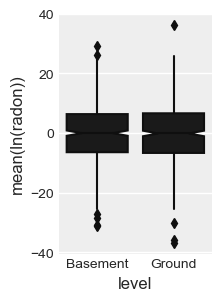

In [27]:
ax = sketch.figure(width=2.1, height=2.9)
sns.boxplot(data=instances, x='type', y='measures', notch=True, color='k', showcaps=False, ax=ax)
sketch.annotation(ax, Labels(title='', xlabel='level', ylabel='mean(ln(radon))'))

<br>
<br>

### Prior Predictive

In [28]:
evidence.prior_predictive

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 500, N: 919)
Coordinates:
  * chain    (chain) int32 0
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * N        (N) int32 0 1 2 3 4 5 6 7 8 ... 910 911 912 913 914 915 916 917 918
Data variables:
    y        (chain, draw, N) float64 6.34 -2.849 -1.918 ... -1.496 -1.758
Attributes:
    created_at:                 2022-11-27T23:01:00.247588
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

<br>
<br>

### Posterior Measures


Notes/references:

* [About `arviz.hdi(.)`](https://arviz-devs.github.io/arviz/api/generated/arviz.hdi.html)

* [About `xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html#xarray.DataArray)

* [xarray.DataArray.groupy](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html#xarray.DataArray.groupby)

* cf. `trace.constant_data['level']` & `trace.constant_data['N']`


<br>

**Posterior Measures: Distributions**

In [29]:
computations = []

for k, v in coords['Level'].items():
    
    points = evidence.posterior['measures'].mean(dim=('chain')).sel(Level=k).squeeze()
    
    instances = pd.DataFrame(data={'measures': points, 'level': np.repeat(v, points.shape[0]), 'type': np.repeat(k, points.shape[0])})
    
    computations.append(instances)

instances = pd.concat(computations, axis=0, ignore_index=True)

logger.info(instances.tail())


      measures  level    type
1995  0.760688      1  Ground
1996  0.802611      1  Ground
1997  0.756269      1  Ground
1998  0.805815      1  Ground
1999  0.802863      1  Ground
2022-11-27 23:01:01.771



<br>

The distributions

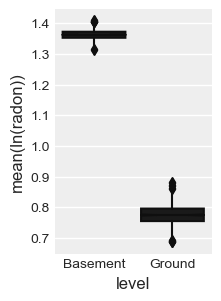

In [30]:
ax = sketch.figure(width=2.1, height=2.9)
sns.boxplot(data=instances, x='type', y='measures', notch=True, color='k', showcaps=False, ax=ax)
sketch.annotation(ax, Labels(title='', xlabel='level', ylabel='mean(ln(radon))'))

<br>
<br>

**Posterior Measures & Standard Deviations: Summaries**

In [31]:
az.summary(evidence)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
measures[Basement],1.363,0.029,1.311,1.419,0.000,0.000,5665.0,2836.0,1.0
measures[Ground],0.775,0.064,0.655,0.896,0.001,0.001,5885.0,3265.0,1.0
sigma,0.791,0.018,0.758,0.825,0.000,0.000,6893.0,3031.0,1.0


<br>
<br>

**Posterior Measures & Standard Deviations: Graphs**

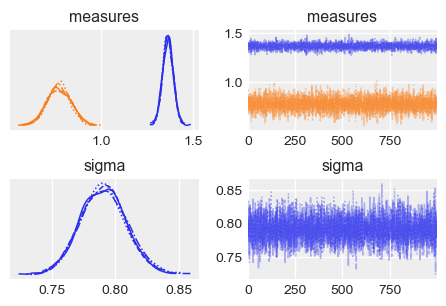

In [32]:
with complete:
    az.plot_trace(data=evidence, figsize=(4.35, 2.95))

<br>

Cf.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000013FED130>,
      dtype=object)

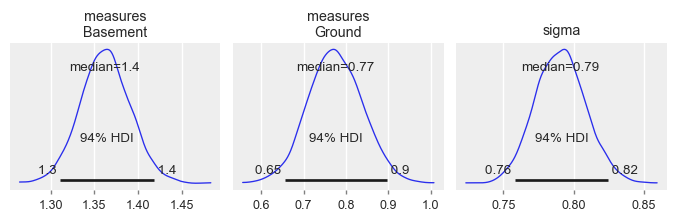

In [33]:
pm.plot_posterior(data=evidence, var_names=['measures', 'sigma'], 
                 figsize=(6.65, 2.1), grid=(1, 3), point_estimate='median', textsize=9)

<br>
<br>

**Posterior Measures Mean**

In [34]:
averages_features = evidence.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:      (Level: 2, LevelCode: 2, CountyIndex: 85)
Coordinates:
  * Level        (Level) <U8 'Basement' 'Ground'
  * LevelCode    (LevelCode) int32 0 1
  * CountyIndex  (CountyIndex) int32 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
Data variables:
    measures     (Level) float64 1.363 0.7749
    sigma        float64 0.7906

<br>

**Posterior Measures High Density Intervals**

Herein, determining the high density posterior intervals via

> ```python
hdi_features = (
    trace.posterior['measures'].groupby(trace.posterior.LevelName).apply(
        lambda x: az.hdi(x, input_core_dims=[['chain', 'draw']]))['measures']
)
hdi_features


is unnecessarily complex, and the resulting object does not include `LevelCode` co$\ddot{o}$rdinates.

<br>


In [35]:
hdi_features = az.hdi(evidence)
hdi_features

<xarray.Dataset>
Dimensions:      (Level: 2, hdi: 2, LevelCode: 2, CountyIndex: 85)
Coordinates:
  * Level        (Level) <U8 'Basement' 'Ground'
  * LevelCode    (LevelCode) int32 0 1
  * CountyIndex  (CountyIndex) int32 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
  * hdi          (hdi) <U6 'lower' 'higher'
Data variables:
    measures     (Level, hdi) float64 1.311 1.419 0.6549 0.8958
    sigma        (hdi) float64 0.7581 0.8247

<br>
<br>

### Posterior Predictive

<br>

**Posterior Predictive Check**

Equivalent:
> ```python 
pm.plot_ppc(data=..., figsize=(2.9, 2.4), num_pp_samples=125, 
            random_seed=RANDOM_SEED, textsize=10)

> ```python 
az.plot_ppc(data=..., figsize=(2.9, 2.4), num_pp_samples=125, 
            random_seed=RANDOM_SEED, textsize=10)

<br>

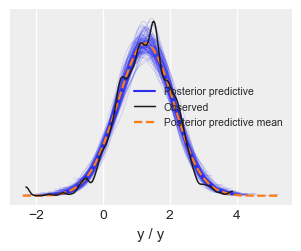

In [36]:
az.plot_ppc(data=evidence, figsize=(2.9, 2.4), num_pp_samples=125, random_seed=RANDOM_SEED, textsize=10)

<br>
<br>

**The posterior predictive high density interval per floor level type**

In [37]:
credibility = lambda x: az.hdi(x, input_core_dims=[["chain", "draw", "N"]])
hdi_predictive = (
    evidence.posterior_predictive.y.groupby(evidence.constant_data.levelcode)
    .apply(credibility)
    .y
)
hdi_predictive

<xarray.DataArray 'y' (levelcode: 2, hdi: 2)>
array([[-0.12709509,  2.85021963],
       [-0.70831413,  2.26768273]])
Coordinates:
  * hdi        (hdi) <U6 'lower' 'higher'
  * levelcode  (levelcode) int64 0 1

<br>

### Graphs

Options:

* `sns.scatterplot(y=evidence.observed_data['y'], x=trace.observed_data['LevelName'], ax=ax)`

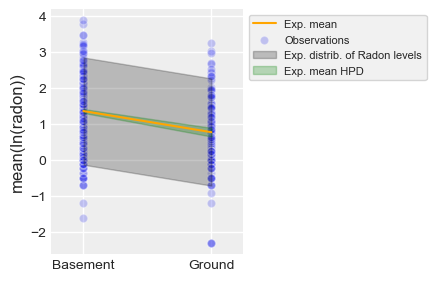

In [38]:
ax = sketch.figure(width=4.25, height=2.7)

evidence.observed_data.plot.scatter(x='LevelCode', y='y', label='Observations', alpha=0.25, ax=ax)

az.plot_hdi(hdi_predictive.levelcode.values, 
            hdi_data=hdi_predictive, 
            fill_kwargs={'alpha': 0.25, 'label': 'Exp. distrib. of Radon levels'}, 
            color='k',
            ax=ax)

az.plot_hdi(hdi_features.LevelCode.values, 
            hdi_data=hdi_features['measures'], 
            fill_kwargs={'alpha': 0.25, 'label': 'Exp. mean HPD'}, 
            color='green',
            ax=ax)

ax.plot(np.arange(averages_features.coords['Level'].shape[0]), 
        averages_features['measures'].values, 
        color='orange',
        label='Exp. mean')

sketch.annotation(ax, Labels(title='', xlabel='', ylabel='mean(ln(radon))'))

ax.set_xlim(-0.25, 1.25)

ax.set_xticks(evidence.posterior['LevelCode'].values)
ax.set_xticklabels(evidence.posterior['Level'].values, rotation=0)

ax.legend(fontsize=8, frameon=True, bbox_to_anchor=(1, 1), loc='upper left')

<br>

### Inference Data

In [39]:
evidence

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

## Unpooled

<br>

The object `coords` has the set of distinct counties, each has a distinct index; ref. `coords['County']`.  &nbsp; In future use [an appropriate geographic code](https://www.nist.gov/system/files/documents/2021/08/11/FIPSCodesReplacementChart2015.pdf). &nbsp;  Additionally, the data object `excerpt` includes a `countyindex` field, whereby the relevant dictionary is $\rightarrow$ `coords['County']`.

> ```python
logger.info(coords.keys())
logger.info(coords.get('County'))
```


<br>

### Model

In [40]:
unpooled = src.models.unpooled.Unpooled(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The county & level groups: (85, 2)
2022-11-27 23:01:10.373


The shape of mu, whereby mu = measures[countyindex, levelcode]: (919,)
2022-11-27 23:01:10.424


y
2022-11-27 23:01:10.453



<br>
<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(unpooled)`

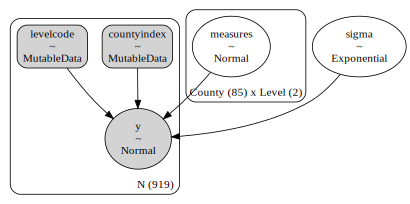

In [41]:
name = 'unpooled.gv'
dag.exc(model=unpooled, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [42]:
alternative = src.models.inference.Inference(model=unpooled).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-11-27 23:01:11.770

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-11-27 23:01:11.772

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-11-27 23:01:15.126

NUTS: [measures, sigma]

NUTS: [measures, sigma]
2022-11-27 23:01:15.128



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
2022-11-27 23:02:08.196

Sampling: [measures, sigma, y]

Sampling: [measures, sigma, y]
2022-11-27 23:02:15.006

Sampling: [y]

Sampling: [y]
2022-11-27 23:02:15.189



In [43]:
alternative = src.models.mapping.Mapping(inferences=alternative, coords=coords).exc()

In [44]:
alternative

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

### Posterior Measures

<br>

**Posterior Measures & Standard Deviations: Summaries**

In [45]:
az.summary(alternative)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"measures[AITKIN, Basement]",0.666,0.411,-0.125,1.417,0.006,0.005,4275.0,2843.0,1.0
"measures[AITKIN, Ground]",0.834,0.737,-0.588,2.135,0.011,0.009,4479.0,3043.0,1.0
"measures[ANOKA, Basement]",0.952,0.102,0.757,1.135,0.001,0.001,4901.0,3197.0,1.0
"measures[ANOKA, Ground]",-0.119,0.410,-0.869,0.669,0.006,0.006,4574.0,2898.0,1.0
"measures[BECKER, Basement]",1.479,0.719,0.099,2.735,0.011,0.008,4414.0,3208.0,1.0
...,...,...,...,...,...,...,...,...,...
"measures[WRIGHT, Basement]",1.675,0.214,1.253,2.064,0.003,0.002,4695.0,2388.0,1.0
"measures[WRIGHT, Ground]",0.886,0.708,-0.461,2.202,0.010,0.008,5554.0,2823.0,1.0
"measures[YELLOW MEDICINE, Basement]",1.217,0.508,0.197,2.132,0.008,0.006,4468.0,2568.0,1.0
"measures[YELLOW MEDICINE, Ground]",-0.087,9.867,-18.343,18.322,0.137,0.165,5150.0,2874.0,1.0


<br>

<br>

**Posterior Measures & Standard Deviations: Graphs**

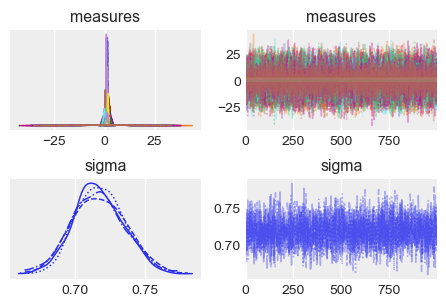

In [46]:
with unpooled:
    az.plot_trace(data=alternative, figsize=(4.35, 2.95))

<br>
<br>

**Posterior Measures: High Density Intervals**

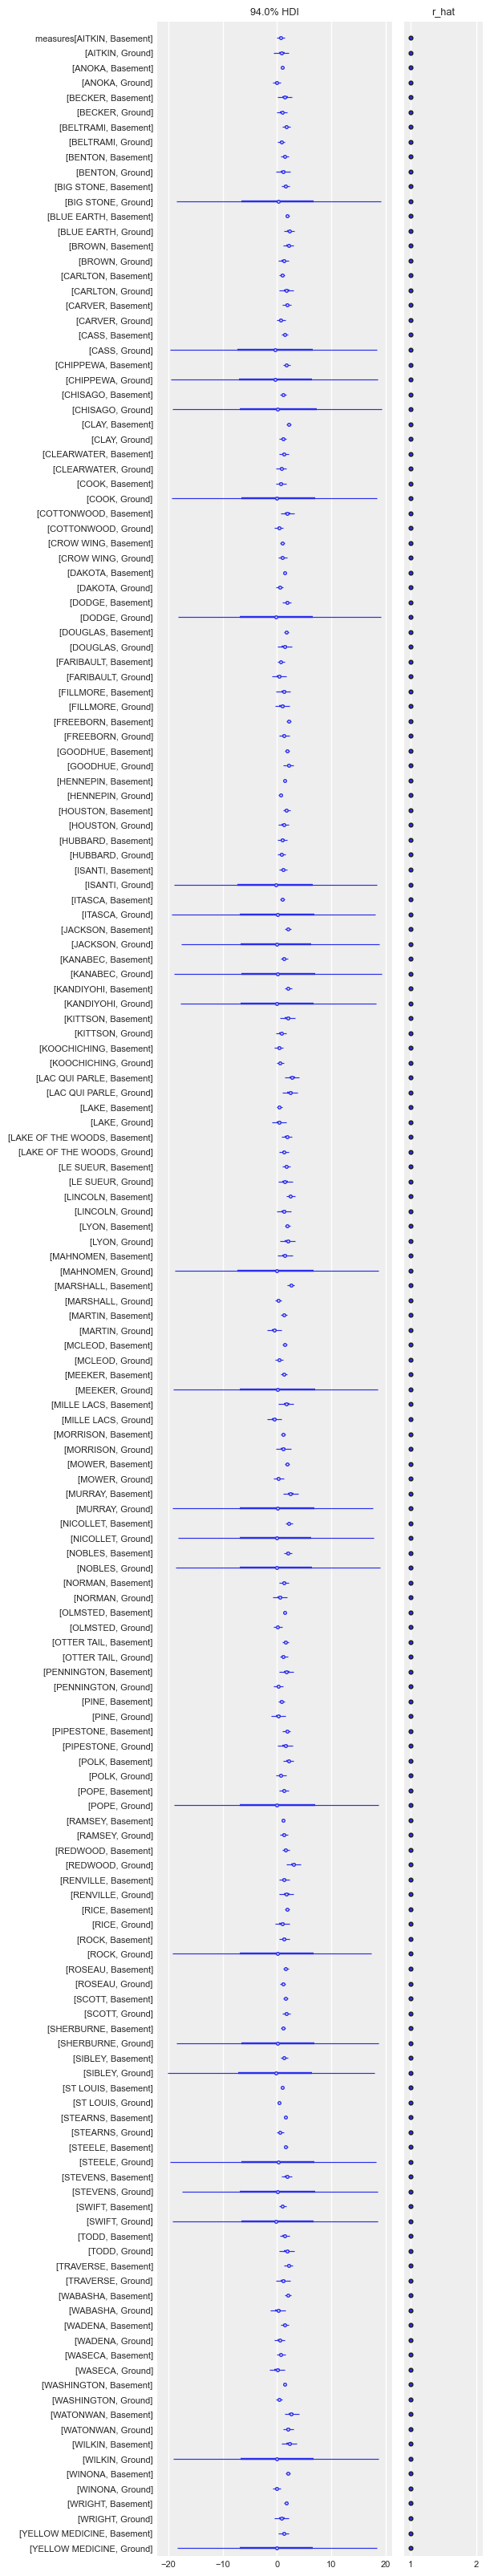

In [47]:
az.plot_forest(
    alternative, var_names='measures', figsize=(6, 32), r_hat=True, combined=True, textsize=8
);

<br>

**Posterior Mean**

In [48]:
averages_features = alternative.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:      (County: 85, Level: 2, LevelCode: 2, CountyIndex: 85)
Coordinates:
  * County       (County) <U17 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * Level        (Level) <U8 'Basement' 'Ground'
  * LevelCode    (LevelCode) int32 0 1
  * CountyIndex  (CountyIndex) int32 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
Data variables:
    measures     (County, Level) float64 0.6661 0.8336 0.952 ... 1.217 -0.08678
    sigma        float64 0.7177

<br>

**Posterior Check**

In [49]:
hdi_features = az.hdi(alternative)
hdi_features

<xarray.Dataset>
Dimensions:      (County: 85, Level: 2, hdi: 2, LevelCode: 2, CountyIndex: 85)
Coordinates:
  * County       (County) <U17 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * Level        (Level) <U8 'Basement' 'Ground'
  * LevelCode    (LevelCode) int32 0 1
  * CountyIndex  (CountyIndex) int32 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
  * hdi          (hdi) <U6 'lower' 'higher'
Data variables:
    measures     (County, Level, hdi) float64 -0.1253 1.417 ... -18.34 18.32
    sigma        (hdi) float64 0.6857 0.7544

<br>
<br>

### Graphs

<br>
<br>

**High Density Intervals, Averages**

For more about `sel(.)` visit [arviz.InferenceData.sel(.)](https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.sel.html).  &nbsp; The # of counties is

> ```python 
len(coords.get('County'))


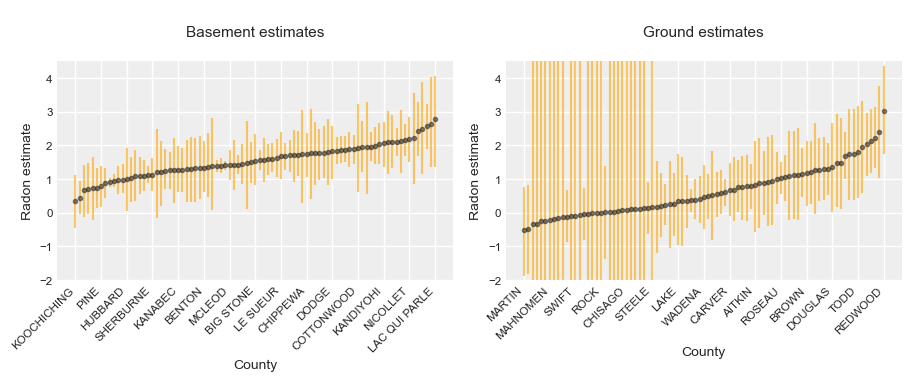

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.7))

xticks = np.arange(0, 86, 6)

fontdict = {'horizontalalignment': 'right', 'fontsize': 8}

for ax, level in zip(axes, ['Basement', 'Ground']):
    
    averages_ = averages_features.sel(Level=level).sortby('measures')
    
    # the HDI limits per County ordered by increasing average, i.e., as above
    hdi_ = hdi_features.sel(Level=level).sortby(averages_.measures)
    
    # the scatter plot of the average value per County
    ax.plot(averages_['County'].values, averages_['measures'].values, 'ok', markersize=3, alpha=0.5);
    
    # high density interval lines
    ax.vlines(
        np.arange(len(coords.get('County'))),
        hdi_.measures.sel(hdi='lower'),
        hdi_.measures.sel(hdi='higher'),
        color='orange',
        alpha=0.6,
    )
    
    
    # titles
    ax.set_title(f'\n{level.title()} estimates\n', fontsize=11)
    
    # x ticks
    ax.set_xticks(xticks)
    ax.set_xticklabels(averages_.County.values[xticks], horizontalalignment='right', rotation=45)
    
    # all ticks
    ax.tick_params(labelsize='x-small')
    
    # limits
    ax.set_ylim(bottom=-2, top=4.5)
    
    # labels
    ax.set_xlabel('County', fontsize=10)
    ax.set_ylabel('Radon estimate', fontsize=10)

<br>
<br>

**Ground Level Dispersions of High Density Intervals**

Ground level posterior `measures`  high density interval data

In [51]:
experiment = hdi_features['measures'].sel(Level='Ground')

<br>

Hence, the differences and their parallel county names

In [52]:
differences = pd.DataFrame(data={'difference': experiment.sel(hdi='higher') - experiment.sel(hdi='lower'), 
                                 'county': experiment['County']})

<br>

Differences and frequencies.

In [53]:
values = frequencies.loc[frequencies['floor'] == coords['Level']['Ground'], ]
dispersions = differences.merge(values, how='left', on='county')
logger.info(dispersions.tail())


    difference           county  countyindex  floor    N
80    1.877177         WATONWAN         80.0    1.0  2.0
81   37.690384           WILKIN          NaN    NaN  NaN
82    1.558911           WINONA         82.0    1.0  3.0
83    2.662840           WRIGHT         83.0    1.0  1.0
84   36.664865  YELLOW MEDICINE          NaN    NaN  NaN
2022-11-27 23:02:49.399



<br>

Some counties do not have any ground level data points

In [54]:
dispersions.loc[:, 'N'] = dispersions['N'].fillna(value=0).array
logger.info(dispersions.tail())


    difference           county  countyindex  floor    N
80    1.877177         WATONWAN         80.0    1.0  2.0
81   37.690384           WILKIN          NaN    NaN  0.0
82    1.558911           WINONA         82.0    1.0  3.0
83    2.662840           WRIGHT         83.0    1.0  1.0
84   36.664865  YELLOW MEDICINE          NaN    NaN  0.0
2022-11-27 23:02:49.418



<br>

The graph below illustrates that the large dispersions, intervals, are due counties that do not have data points.

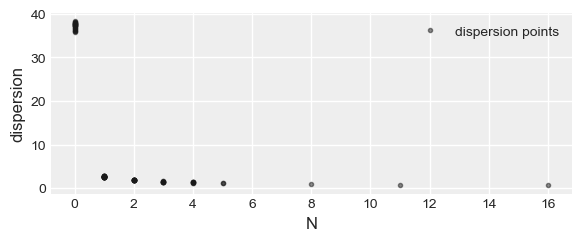

In [55]:
ax = sketch.figure(width=5.7, height=2.3)

ax.plot(dispersions['N'].array, dispersions['difference'].array, 'ok', markersize=3, alpha=0.5, label='dispersion points');
sketch.annotation(ax, Labels(title='', xlabel='N', ylabel='dispersion'))
ax.legend(loc='upper right', fontsize='small');

<br>
<br>

**Funnel**

<br>
<br>

### Inference Data

In [56]:
alternative

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [57]:
excerpt.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,ln_radon,countyindex
5404,5081,MN,MN,27,55735,5,1,1,3,N,...,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054,0.832909,0
5405,5082,MN,MN,27,55748,5,1,0,4,Y,...,14.5,471.366223,0,0,1,AITKIN,27001,0.502054,0.832909,0
5406,5083,MN,MN,27,55748,5,1,0,4,Y,...,9.6,433.316718,0,0,1,AITKIN,27001,0.502054,1.098612,0
5407,5084,MN,MN,27,56469,5,1,0,4,Y,...,24.3,461.623670,0,0,1,AITKIN,27001,0.502054,0.095310,0
5408,5085,MN,MN,27,55011,3,1,0,4,Y,...,13.8,433.316718,0,0,3,ANOKA,27003,0.428565,1.163151,1


<br>

Inspect

In [58]:
averages_features['measures'].sel(County='AITKIN')

<xarray.DataArray 'measures' (Level: 2)>
array([0.66610606, 0.83358746])
Coordinates:
    County   <U17 'AITKIN'
  * Level    (Level) <U8 'Basement' 'Ground'

In [59]:
alternative.observed_data['y'][alternative.observed_data.coords['County'] == 'AITKIN']

<xarray.DataArray 'y' (N: 4)>
array([0.83290912, 1.09861229, 0.09531018, 0.83290912])
Coordinates:
  * N            (N) int32 1 2 3 0
    Level        (N) <U8 'Basement' 'Basement' 'Basement' 'Ground'
    LevelCode    (N) int32 0 0 0 1
    County       (N) <U17 'AITKIN' 'AITKIN' 'AITKIN' 'AITKIN'
    CountyIndex  (N) int32 0 0 0 0

<br>
<br>
<br>

## Partial

### Model

In [21]:
partial = src.models.partial.Partial(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The shape of mu, whereby mu = intercepts[countyindex]: (919,)
2022-11-28 15:58:05.379


likelihood
2022-11-28 15:58:05.399



<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(partial)`

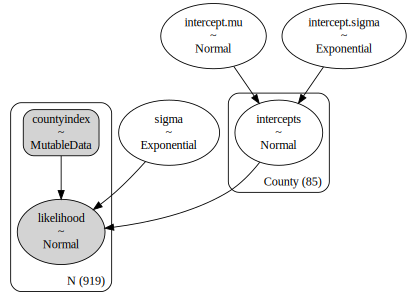

In [22]:
name = 'partial.gv'
dag.exc(model=partial, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))